In [1]:
import torch
import sys
import logging
import os 
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc, confusion_matrix, classification_report,precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, precision_recall_curve,precision_recall_curve
from imblearn.pipeline import Pipeline
sys.path.append("VAE/")
sys.path.append("ML/")
import importlib
import train_loops
import wandb
from pathlib import Path
from utils import utils,eval_utils,plotting_utils,split
import run
from configs.config_cytomodel import config
device = 'cuda' if torch.cuda.is_available() else 'cpu'
importlib.reload(utils)
import matplotlib.pyplot as plt
run.seed_everything(42)
from models.vae import VAE
import re
import train_svm
from svm_config import *
import seaborn as sns
from feature_change import features_gen

In [2]:
importlib.reload(eval_utils)
dset, loader, dset_test, loader_test = run.get_datasets_from_config(config, 'MEFs.npy',train_size_x = 0.8)
print("sample train data")
f, axs = utils.plot_sample_data(loader)

/home/ubuntu/texasfile/Rupture_project/o2vae/o2vae-master/codes_git/VAE/data/
sample train data


In [3]:
model = run.start_training(loader,dset_test,  do_train = False,)

2025-04-08 17:39:13,546 - INFO - Found checkpoint at /home/ubuntu/texasfile/Rupture_project/o2vae/o2vae-master/codes_git/VAE/model_training_checkpoints/lr0.005_epoch_100.pth
2025-04-08 17:39:13,546 - ERROR - Failed to load checkpoint /home/ubuntu/texasfile/Rupture_project/o2vae/o2vae-master/codes_git/VAE/model_training_checkpoints/lr0.005_epoch_100.pth: local variable 'device' referenced before assignment
2025-04-08 17:39:13,547 - INFO - Starting training from epoch 1.
2025-04-08 17:39:13,548 - INFO - Found checkpoint at /home/ubuntu/texasfile/Rupture_project/o2vae/o2vae-master/codes_git/VAE/model_training_checkpoints/lr0.005_epoch_100.pth
2025-04-08 17:39:13,549 - ERROR - Failed to load checkpoint /home/ubuntu/texasfile/Rupture_project/o2vae/o2vae-master/codes_git/VAE/model_training_checkpoints/lr0.005_epoch_100.pth: local variable 'device' referenced before assignment
2025-04-08 17:39:13,549 - INFO - Starting training from epoch 1.


32
[12, 19, 19, 25, 32, 64]
[192, 96, 96, 48, 48, 48, 48]
Encoder type <class 'e2scnn.E2SFCNN'>
Decoder type <class 'models.decoders.cnn_decoder.CnnDecoder'>
Bottleneck dims 32
Loss func: bce, beta=0.01 loss aligns output: True 
Parameter counts: 
 encoder 590,790
 decoder 357,409
 total   948,199
/home/ubuntu/texasfile/Rupture_project/o2vae/o2vae-master/codes_git/VAE/model_training_checkpoints
/home/ubuntu/texasfile/Rupture_project/o2vae/o2vae-master/codes_git/VAE/model_training_checkpoints/lr0.005_epoch_100.pth
/home/ubuntu/texasfile/Rupture_project/o2vae/o2vae-master/codes_git/VAE/model_training_checkpoints/lr0.005_epoch_100.pth


2025-04-08 17:39:13,783 - INFO - Found checkpoint at /home/ubuntu/texasfile/Rupture_project/o2vae/o2vae-master/codes_git/VAE/model_training_checkpoints/lr0.005_epoch_100.pth


done
/home/ubuntu/texasfile/Rupture_project/o2vae/o2vae-master/codes_git/VAE/model_training_checkpoints/lr0.005_epoch_100.pth


2025-04-08 17:39:14,358 - INFO - Loaded checkpoint '/home/ubuntu/texasfile/Rupture_project/o2vae/o2vae-master/codes_git/VAE/model_training_checkpoints/lr0.005_epoch_100.pth' (epoch 100)


done


# analyzing the trained model performace on our dataset

In [5]:
df = pd.read_csv('VAE/data/df.csv')
cells_np = np.load('VAE/data/cells.npy')
cells_np = np.expand_dims(cells_np[:,:,:,0], axis=1)
cells_np = torch.from_numpy(cells_np).float()
nucs_np = np.load( 'VAE/data/nucs.npy')
nucs_np = np.expand_dims(nucs_np[:,:,:,0], axis=1)
nucs_np = torch.from_numpy(nucs_np).float()

df = df[df['ruptured_man'].notna()]
cells_np = cells_np[df.index.tolist()]
nucs_np = nucs_np[df.index.tolist()]
labels = df['ruptured_man'].astype(int).values 
print(f"Tensor shape: {nucs_np.shape}")
print(f"Tensor shape: {cells_np.shape}")

embeddings_cells=utils.get_model_embeddings_from_tensors(model,cells_np,batch_size=64, do_progress_bar=True, device="cuda",return_labels=False,)[0]
embeddings_nucs= utils.get_model_embeddings_from_tensors(model,nucs_np,batch_size=64, do_progress_bar=True, device="cuda",return_labels=False,)[0]

Tensor shape: torch.Size([718, 1, 128, 128])
Tensor shape: torch.Size([718, 1, 128, 128])


100%|██████████| 12/12 [00:01<00:00,  7.60it/s]


In [6]:
model.eval().cpu() 
for to_plot in ['cells.npy', 'nucs.npy']:
    dset_cell, loader_cell, dset_test_cell, loader_test_cell = run.get_datasets_from_config(config, to_plot,train_size_x = 0.99)
    x,y = next(iter(loader_cell))
    reconstruct_grid = eval_utils.reconstruction_grid(model, x, align=False)
    reconstruct_grid_aligned = eval_utils.reconstruction_grid(model, x, align=True)
    f,axs = plt.subplots(1,2, figsize=(50,50), dpi = 250)
    axs[0].imshow(reconstruct_grid)
    axs[1].imshow(reconstruct_grid_aligned)
    print("Left: reconstructions.")
    print("Right: reconstructions where output is re-algined to the input. ")
    axs[0].set_axis_off();  axs[1].set_axis_off()
    plt.show()


/home/ubuntu/texasfile/Rupture_project/o2vae/o2vae-master/codes_git/VAE/data/
Left: reconstructions.
Right: reconstructions where output is re-algined to the input. 


/home/ubuntu/texasfile/Rupture_project/o2vae/o2vae-master/codes_git/VAE/data/
Left: reconstructions.
Right: reconstructions where output is re-algined to the input. 


Processing batch starting at index 0
Processing batch starting at index 100
Processing batch starting at index 200
Processing batch starting at index 300
Processing batch starting at index 400
Processing batch starting at index 500
Processing batch starting at index 600
Processing batch starting at index 700
Processing batch starting at index 0
Processing batch starting at index 100
Processing batch starting at index 200
Processing batch starting at index 300
Processing batch starting at index 400
Processing batch starting at index 500
Processing batch starting at index 600
Processing batch starting at index 700
Reconstruction metrics (mean ± std):
BCE - Cell: 0.0884 ± 0.0890
BCE - Nucleus: 0.0582 ± 0.0432
MSE - Cell: 0.0195 ± 0.0100
MSE - Nucleus: 0.0142 ± 0.0067


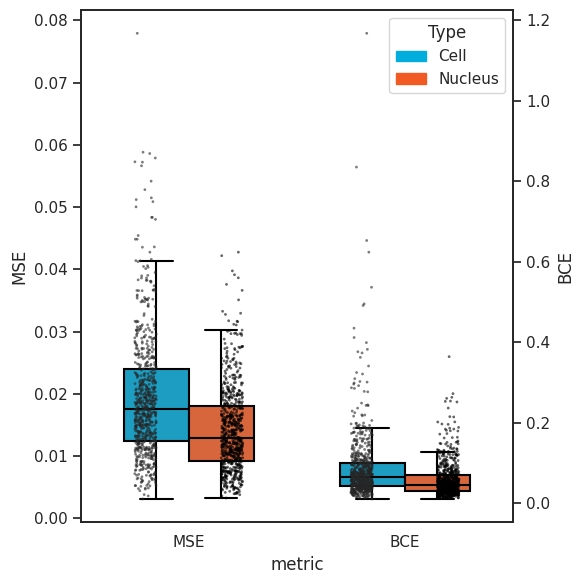

In [7]:
plotting_utils.compute_and_plot_metrics(model, cells_np, nucs_np, device, batch_size=100)

# Umap Analysis

Shapes: (718, 32) (1436, 32)


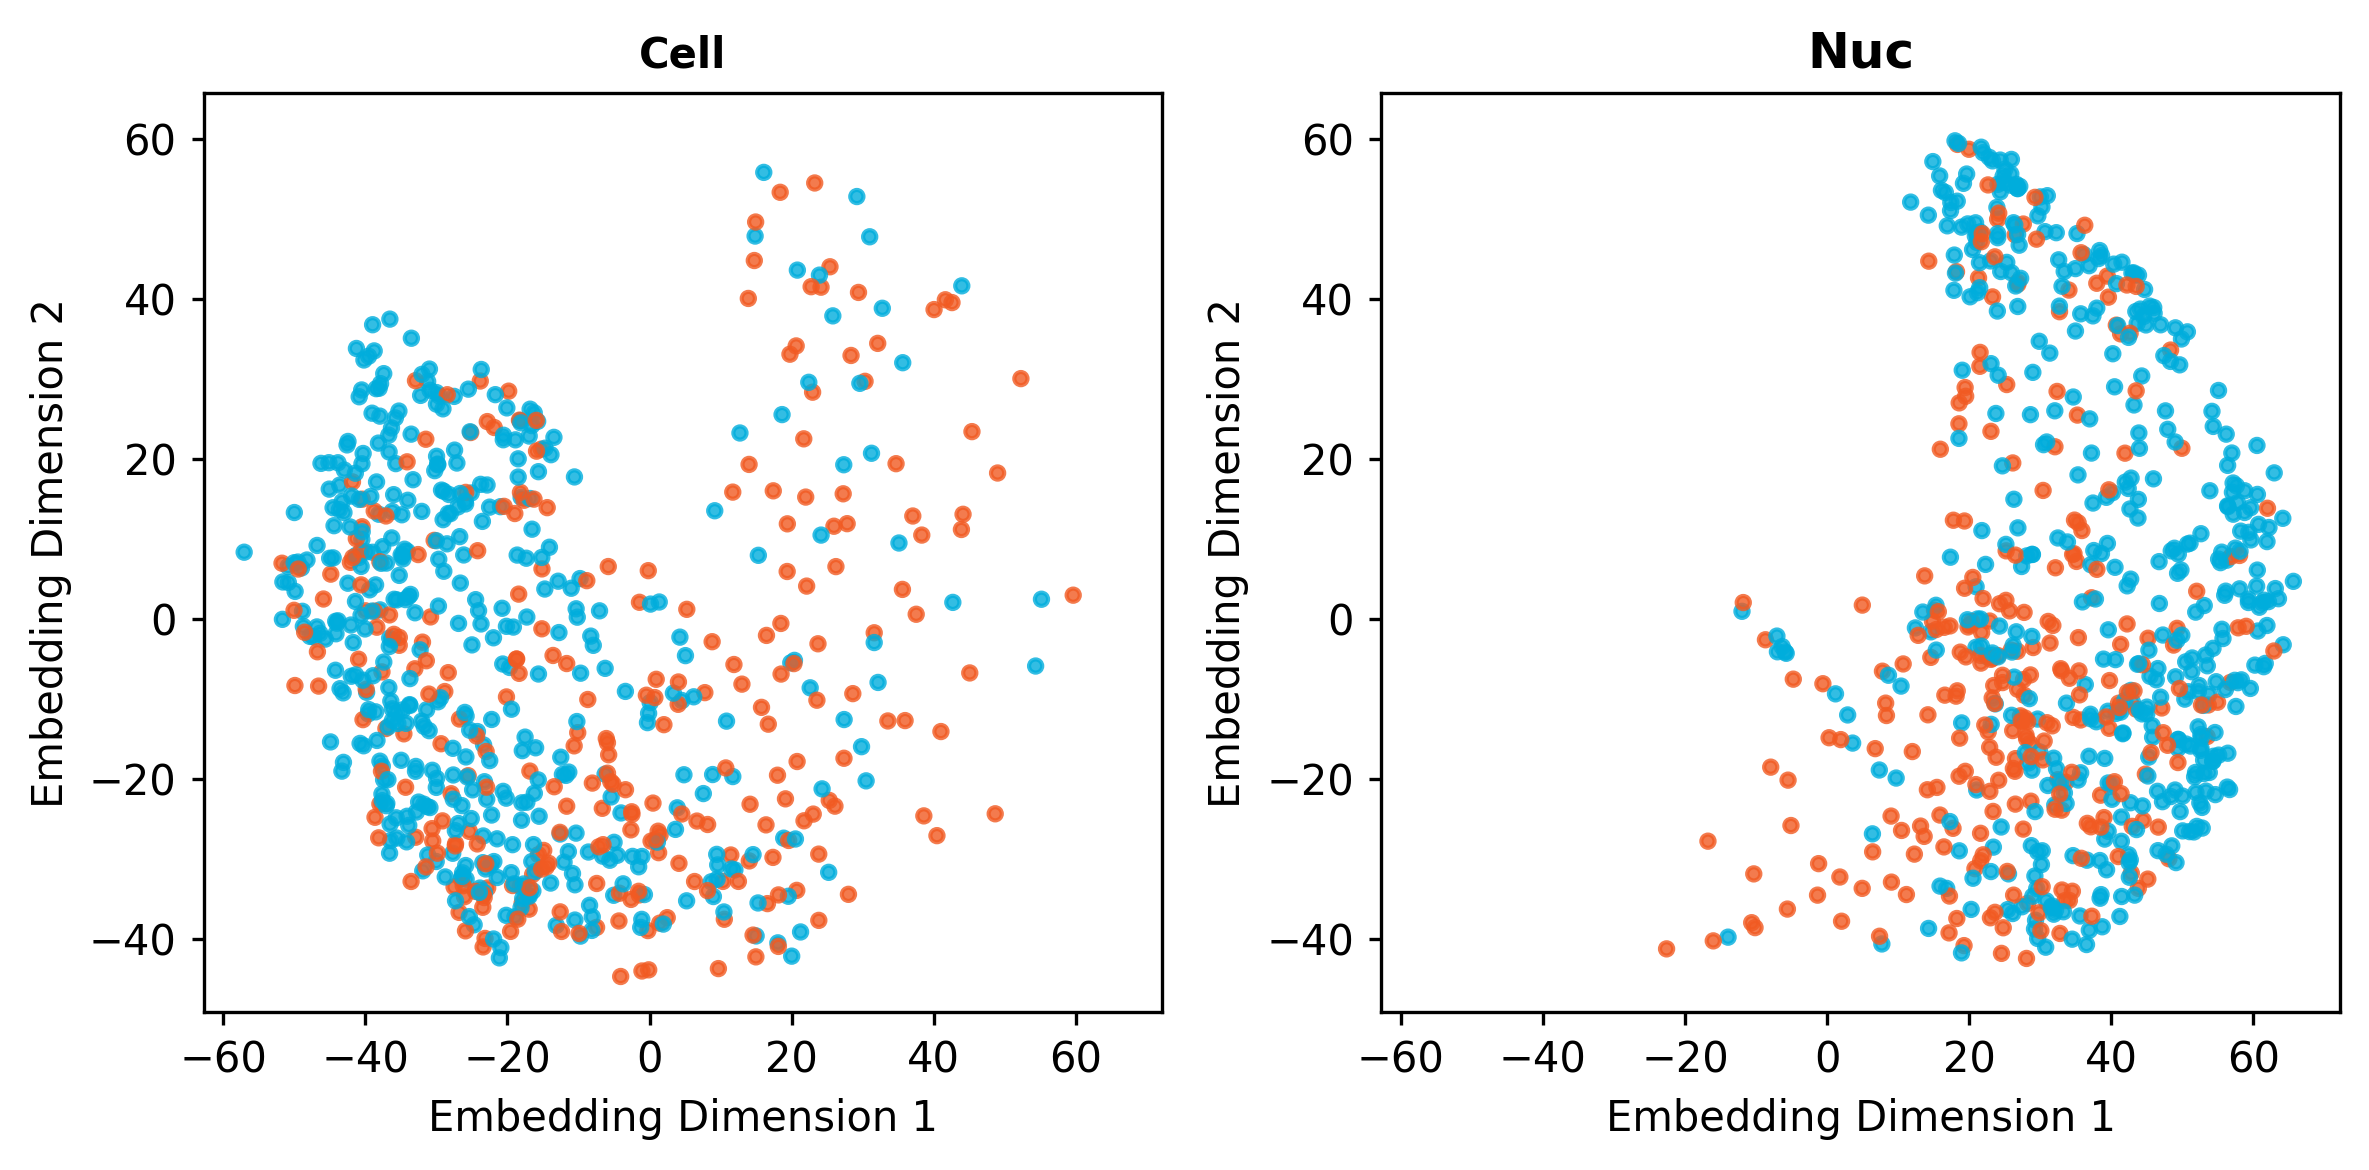

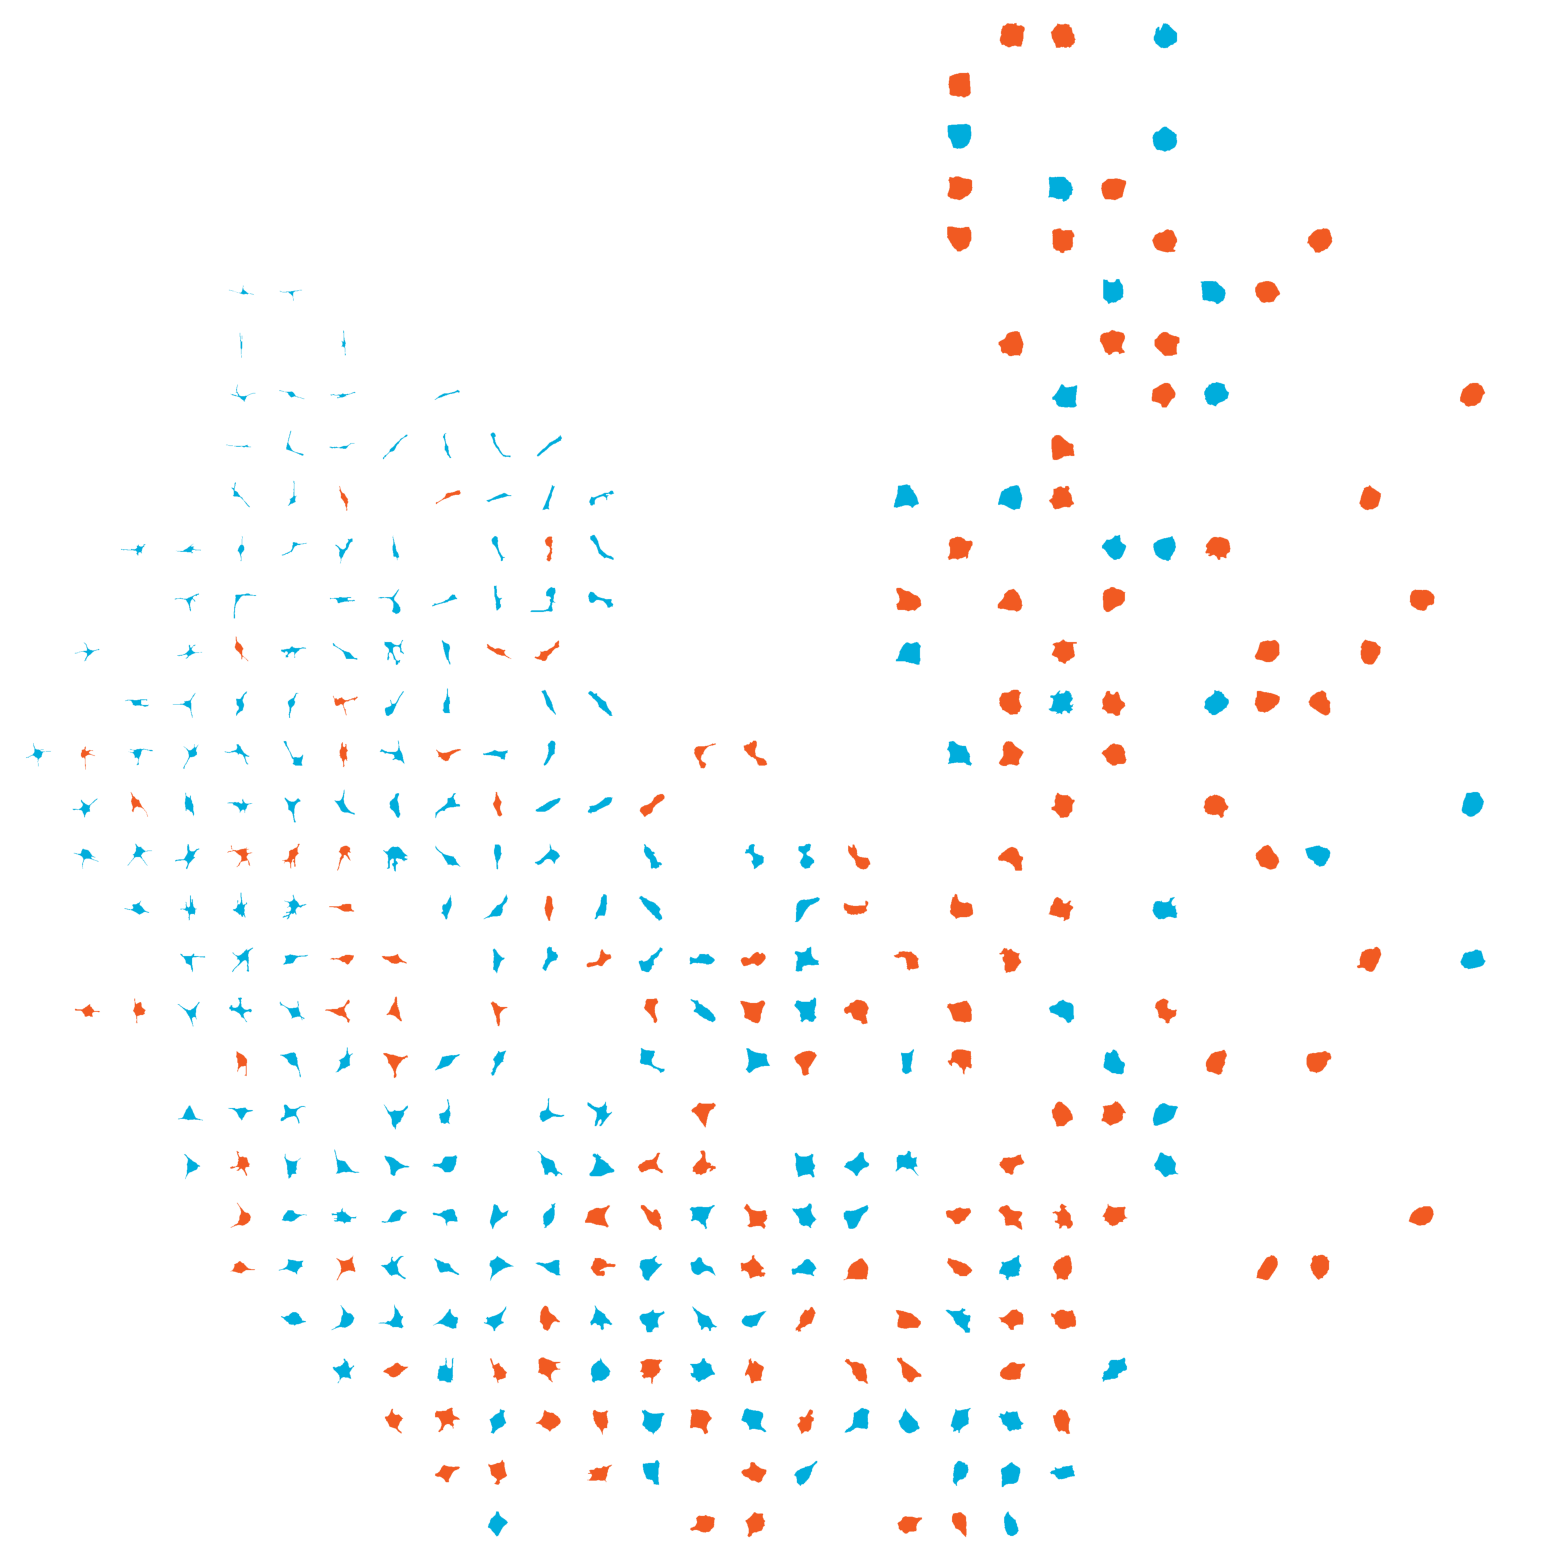

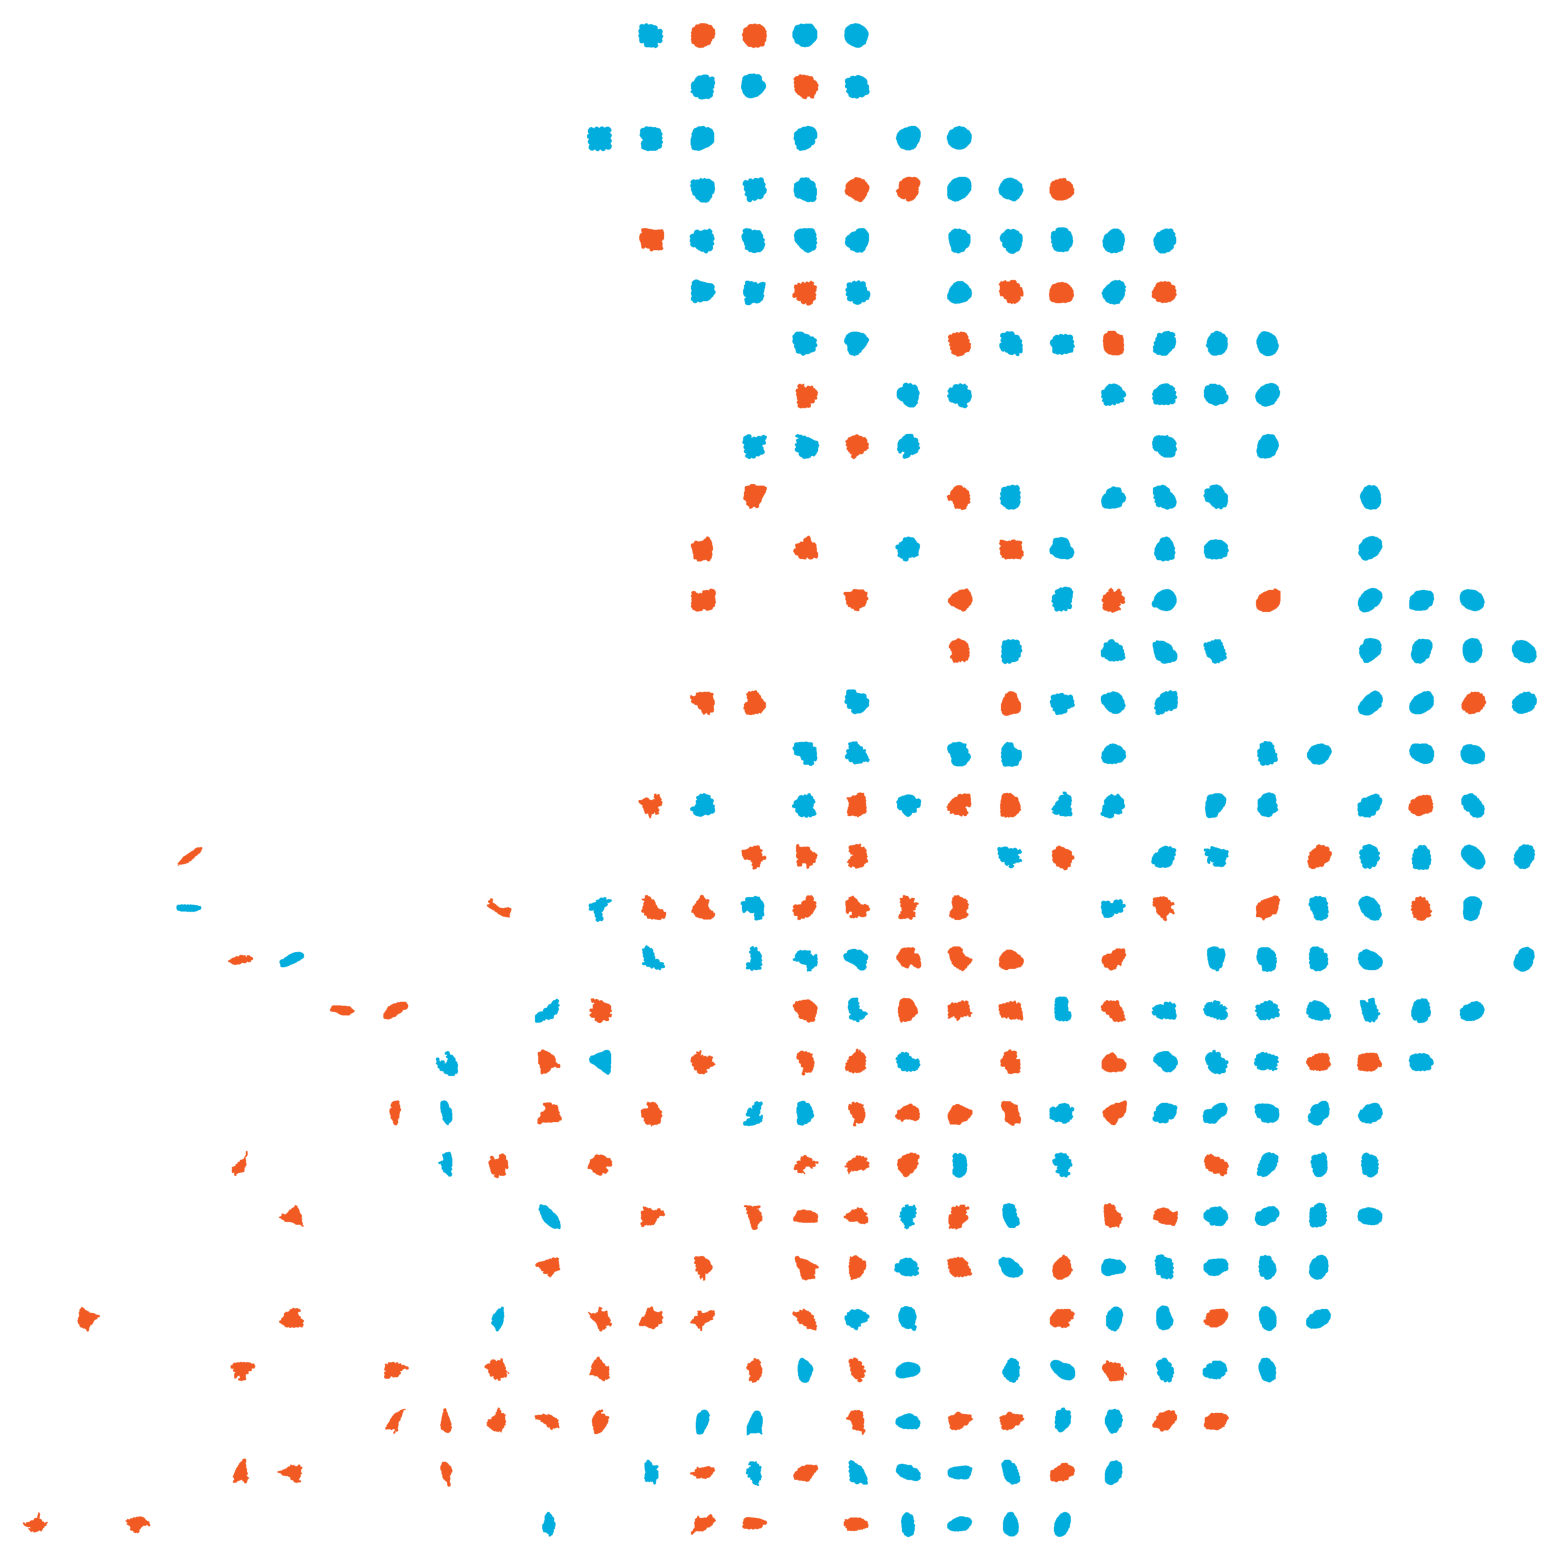

In [8]:
fig, axes, cell_embeds_umap ,nuc_embeds_umap  = plotting_utils.plot_umap_scatter(embeddings_cells, embeddings_nucs, labels)
plotting_utils.plot_umap_embed(cells_np[:,0,:,:],cell_embeds_umap,labels)
plotting_utils.plot_umap_embed(nucs_np[:,0,:,:],nuc_embeds_umap,labels)

# Splitting for Train and Test and Training

In [9]:
feature_names, X_train, X_test,y_train, y_test , df_train, df_test ,  cells_train, cells_test,  nucs_train , nucs_test = split.prep_data(df,embeddings_cells ,embeddings_nucs,cells_np,nucs_np)

In [10]:
# best_params = train_svm.hyper_param_svm(X_train, y_train,n_trials = 200) 
svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(**BEST_PARAMS))
])
svm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm',
                 SVC(C=421.6699936797758, coef0=0.6569561965570723, degree=2,
                     gamma=0.00021129844913526583, kernel='poly',
                     probability=True, random_state=42))])

# SVM Model Evaluation

In [ ]:
train_svm.evaluate_svm_pipeline(svm_pipeline, X_test, X_train, y_test, y_train)

# SHAP Analysis

In [12]:
top_features, shap_df = train_svm.evaluate_shap(svm_pipeline, X_train, X_test, feature_names, save_path=None)

PermutationExplainer explainer:  43%|████▎     | 110/258 [00:36<00:45,  3.22it/s]
KeyboardInterrupt



# Features impact of Shape

In [ ]:
new_samples_df = features_gen.generate_new_samples(X_test, feature_names, top_features, other_features, cell_features, nuc_features,svm_pipeline, n=8, k=5)
images_dict = features_gen.process_samples_and_generate_images(new_samples_df, feature_names, cell_features, nuc_features, model, cells_test, nucs_test)

2025-04-06 23:40:16,550 - INFO - Model moved to GPU.
2025-04-06 23:40:16,552 - INFO - Grouped data by sample_name and feature_name.
2025-04-06 23:40:16,577 - INFO - Processing sample 0 with feature embed_cell_16.
2025-04-06 23:40:16,654 - INFO - Generated image for sample 0 and feature embed_cell_16.
2025-04-06 23:40:16,713 - INFO - Generated image for sample 0 and feature embed_cell_16.
2025-04-06 23:40:16,770 - INFO - Generated image for sample 0 and feature embed_cell_16.
2025-04-06 23:40:16,803 - INFO - Generated image for sample 0 and feature embed_cell_16.
2025-04-06 23:40:16,840 - INFO - Generated image for sample 0 and feature embed_cell_16.
2025-04-06 23:40:16,842 - INFO - Processing sample 0 with feature embed_cell_28.
2025-04-06 23:40:16,873 - INFO - Generated image for sample 0 and feature embed_cell_28.
2025-04-06 23:40:16,905 - INFO - Generated image for sample 0 and feature embed_cell_28.
2025-04-06 23:40:16,937 - INFO - Generated image for sample 0 and feature embed_cel

('0', 'embed_nuc_11')
sample_name, feature_name: 0 embed_nuc_11


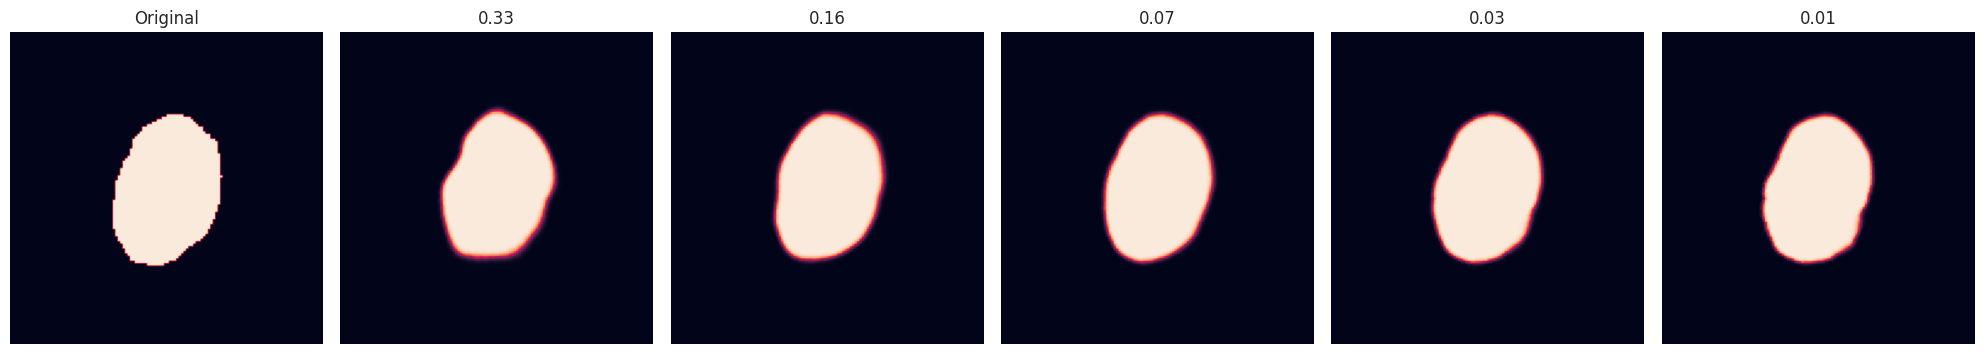

('1', 'embed_nuc_11')
sample_name, feature_name: 1 embed_nuc_11


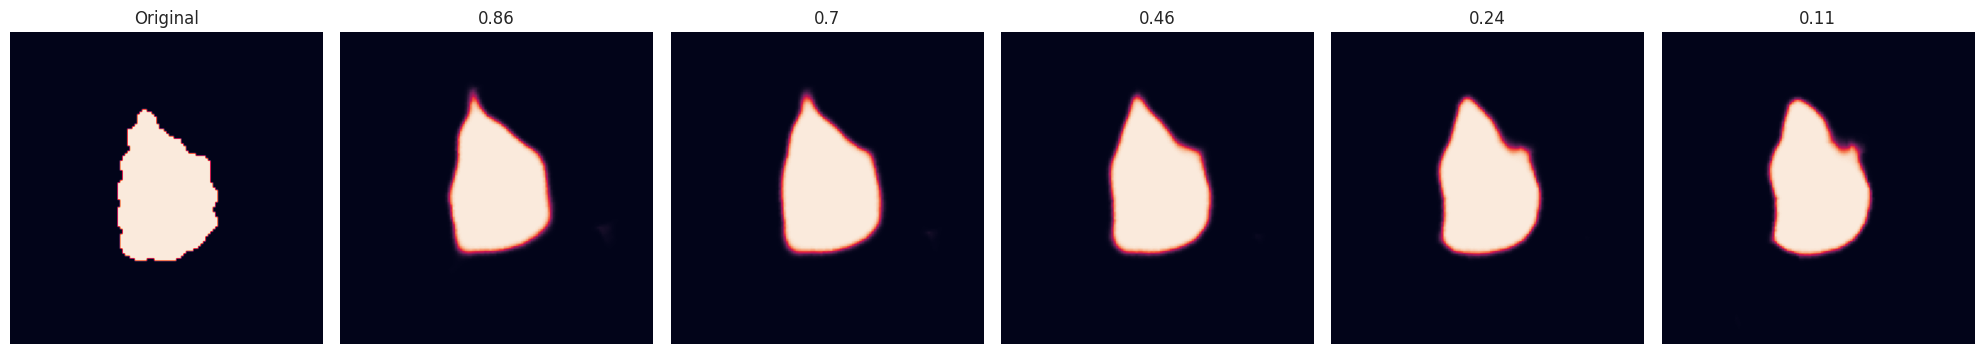

('10', 'embed_nuc_11')
sample_name, feature_name: 10 embed_nuc_11


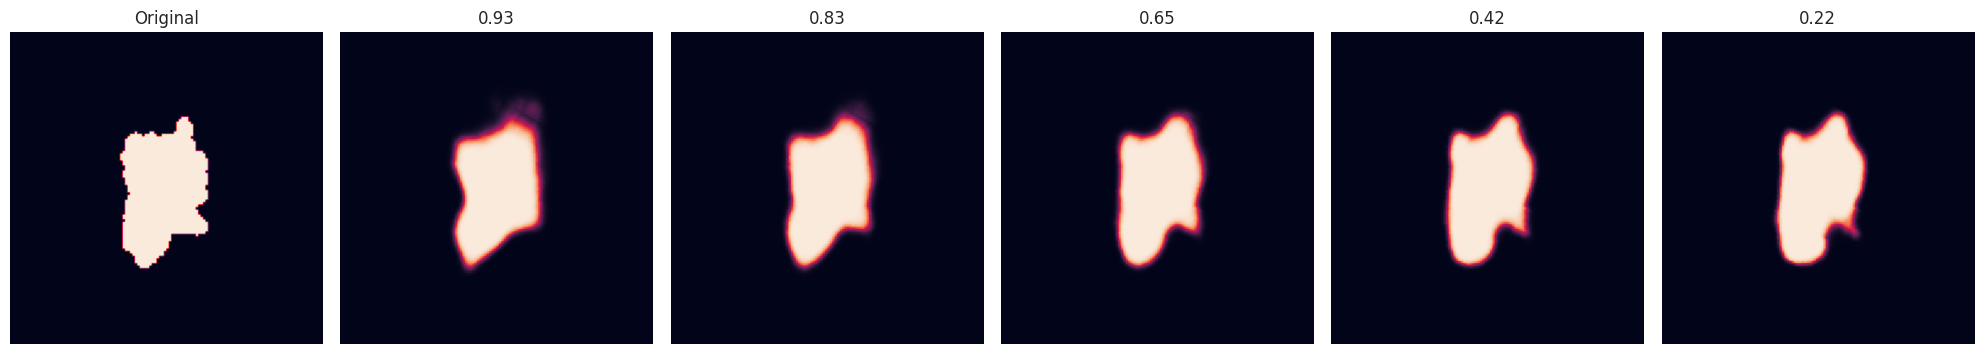

('100', 'embed_nuc_11')
sample_name, feature_name: 100 embed_nuc_11


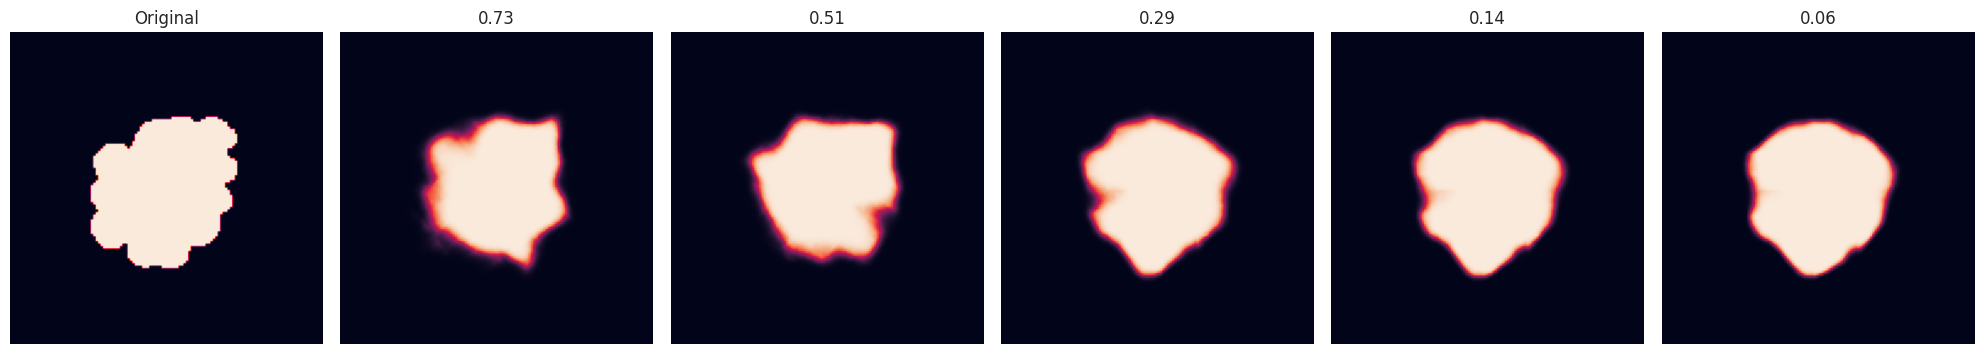

('101', 'embed_nuc_11')
sample_name, feature_name: 101 embed_nuc_11


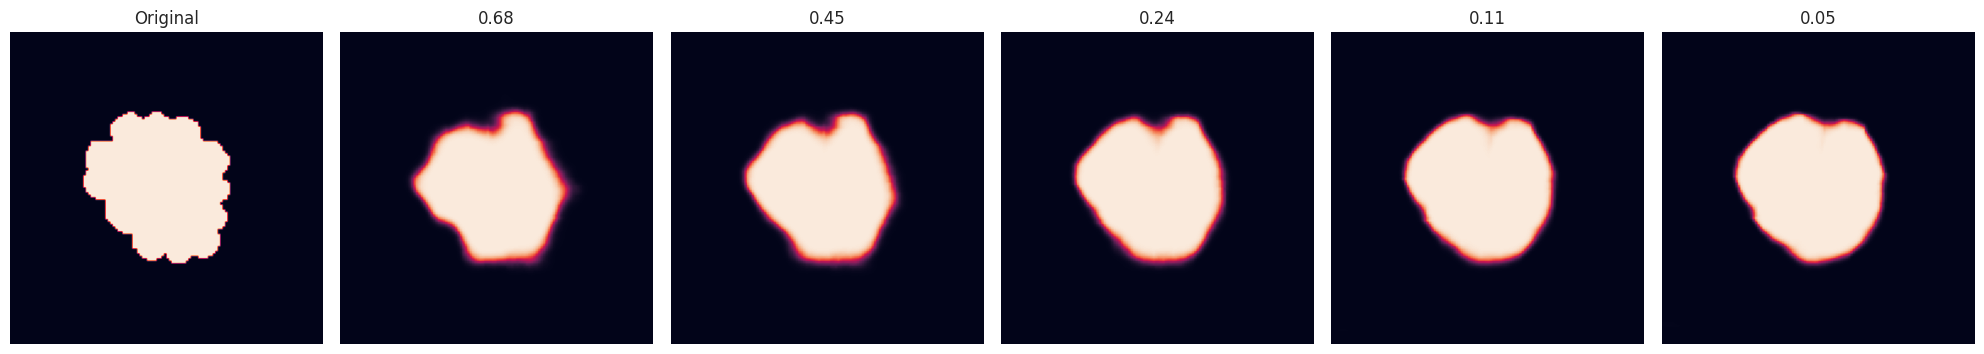

('102', 'embed_nuc_11')
sample_name, feature_name: 102 embed_nuc_11


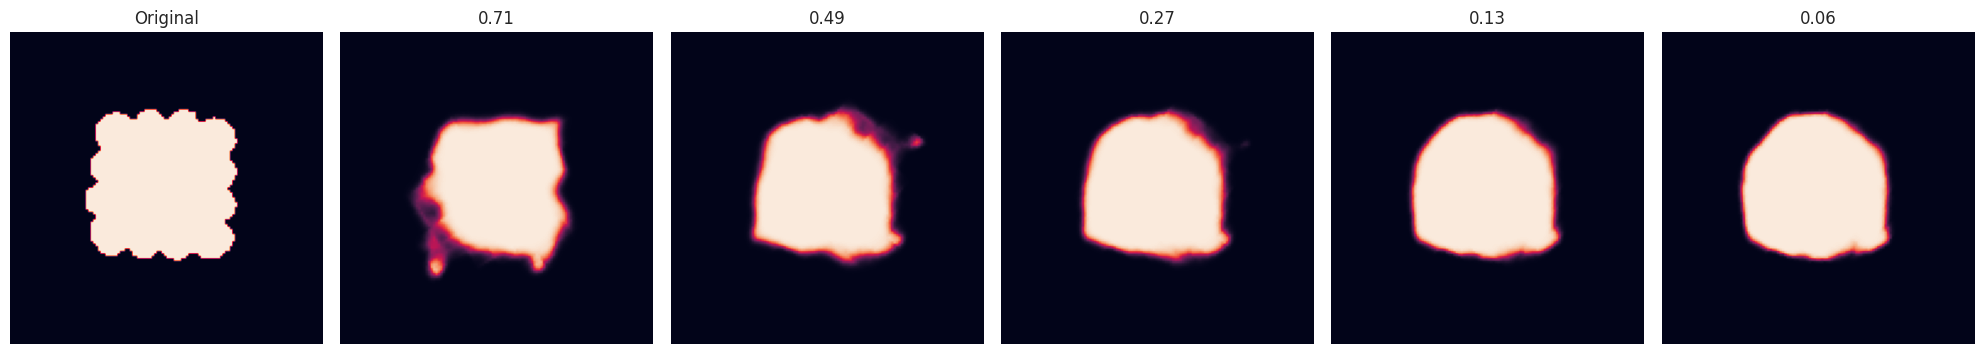

('103', 'embed_nuc_11')
sample_name, feature_name: 103 embed_nuc_11


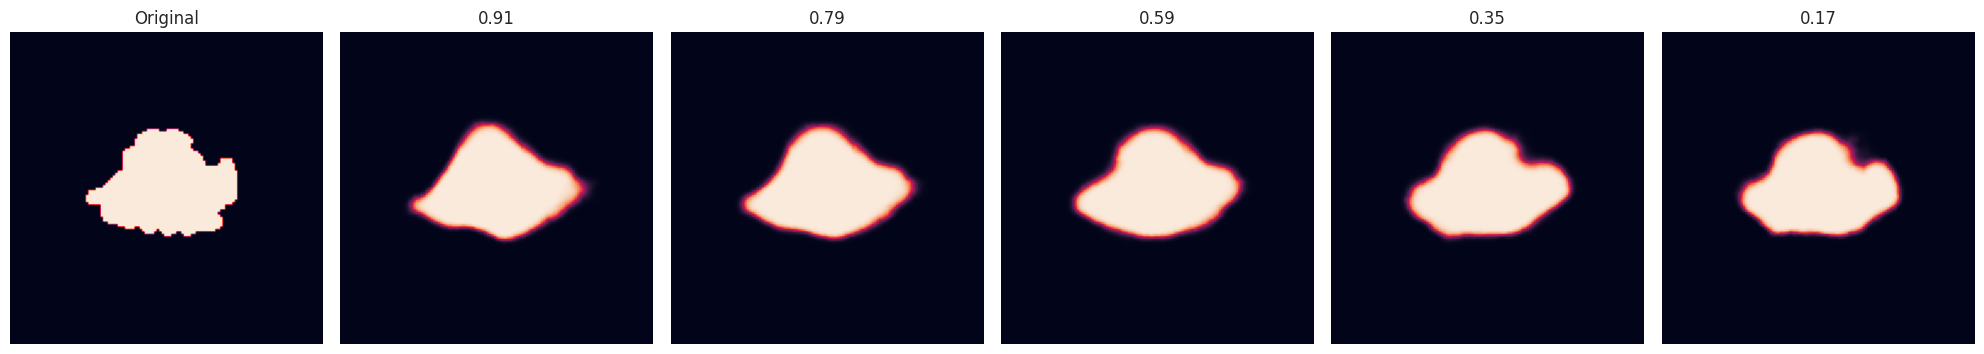

('104', 'embed_nuc_11')
sample_name, feature_name: 104 embed_nuc_11



KeyboardInterrupt



In [17]:
features_gen.show_figs(images_dict, cells_test, nucs_test)